# Day 10 Pre-Class Assignment:<br> Numerical Integration: Romberg, Higher-Order, and  Gaussian Quadrature
### <p style="text-align: right;"> &#9989; Cesarine Graham</p>


## Goals of this assignment

The goals of this assignment are:

* Learn new numerical integral methods:
   * Romberg integration
   * A higher-order integration method
   * Gaussian Quadrature
* Hands-on example to see Romberg integration work
* How to use SciPy for these integration methods

## Assignment instructions

Upload the assignment to Gradescope before 5PM the day of the next class.

---
## Part 0: Why Numerical Integration?
One of the most basic but also most important applications of computers in physics is the evaluation of integrals and derivatives.
Numerical evaluation of integrals is a particularly crucial topic, because integrals occur in physical calculations and, while some integrals can be done analytically in closed form, most cannot.
They can, however, usually be done on a computer (or supercomputer).
In this week's classes, we will examine a number of different techniques for evaluating integrals and discuss their associated errors.

## Part 1: Romberg Integration

We can do even better than the adaptive method of the last session with only a little more effort.
Let us go back to the trapezoidal rule again.

### 1.1 Learn about Romberg Integration
Let's learn about Romberg integration by watching the video below (and looking at a simple example).

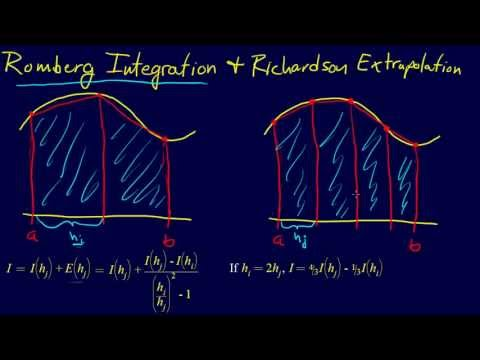

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("HtkylnbJklE",width=640,height=340)
# Direct link on YourTube:https://www.youtube.com/watch?v=QYyjRh67y3o
# Direct link on https://www.youtube.com/watch?v=HtkylnbJklE

To summarize what we learn from this video:

Suppose $R_{i,m}$ is an estimate calculated at the $i$th round of the doubling procedure with error of order $h^{2m}$

$$
R_{i,m+1} = R_{i,m} + \frac{R_{i,m} − R_{i-1,m}}{4^m − 1}
$$

which is accurate to order $h^{2m+1}$ with an error of order $h^{2m}$.


To make use of these results in practice we do the following:

1. We calculate our first two estimates of the integral using the regular trapezoidal rule: $I_1 = R_{1,1}$ and $I_2 = R_{2,1}$.

1. From these, we calculate the more accurate estimate $R_{2,2}$ using the above equation.
This is as much as we can do with only the two starting estimates.

1. Now, we calculate the next trapezoidal-rule estimate $I_3 = R_{3,1}$, and from this, we calculate $R_{3,2}$, and then $R_{3,3}$.

1. At each successive stage, we compute one more trapezoidal-rule estimate $I_i = R_{i,1}$, and from it, with very little extra effort, we can calculate $R_{i,2},\ldots, R_{i,i}$.

### 1.2 Apply Romberg integration
Now, let's test your understanding by trying out a simple example.
In the following cell, use the Romberg integration rule to calculate the integral of $x^4-2x+1$ from $x=0$ to $x=2$.
List your results for $R_{1,1}, R_{2,1}, R_{2,2}, \ldots$ up to $R_{3,3}$.
Compare with your results from the previous pre-class notebook estimate using trapezoidal rule.

In [4]:
def romberg_integration(f, a, b, n):
    # initializing Romberg integration table
    R = [[0] * (i+1) for i in range(n)]
    # integrating over the num of iterations
    for i in range(n):
        # calc the step size
        h = (b - a) / 2**i
        # calc the first column of the current row using the trapezoidal rule
        R[i][0] = sum(f(a + (k + 0.5) * h) for k in range(2**i)) * h
        # iterating over the columns of the current row
        for m in range(1, i + 1):
            # doubling procedure 
            R[i][m] = R[i][m-1] + (R[i][m-1] - R[i-1][m-1]) / (4**m - 1)
    # returning Romberg integration table
    return R

# function to integrate
def func(x):
    return x**4 - 2*x + 1

a = 0
b = 2
n = 3
romberg_table = romberg_integration(func, a, b, n)

# printing Romberg integration table
for i, row in enumerate(romberg_table):
    print(f"R_{i+1}: {row}")

R_1: [0.0]
R_2: [3.125, 4.166666666666667]
R_3: [4.0703125, 4.385416666666667, 4.4]


<font color='blue'>
    
From the previous PC, we found the integral approximation to be $\approx 4.5$ using the Trapezoidal rule.

### 1.3 Use SciPy function
We are not going to write this integration function on our own but will use SciPy's function instead.
Check out the example on how to use this SciPy function [here](https://www.geeksforgeeks.org/python-scipy-integrate-romberg-method/)
and repeat the above integral using the SciPy function.

In [2]:
# your code here

import numpy as np
from scipy import integrate

# Define the function
f = lambda x: x**4 - 2*x + 1

# Integration limits
a = 0  # Lower limit
b = 2  # Upper limit

# Perform Romberg integration
result = integrate.romberg(f, a, b, show=True)

print("Result:", result)

Romberg integration of <function vectorize1.<locals>.vfunc at 0x000001DB94609DC0> from [0, 2]

 Steps  StepSize   Results
     1  2.000000 14.000000 
     2  1.000000  7.000000  4.666667 
     4  0.500000  5.062500  4.416667  4.400000 
     8  0.250000  4.566406  4.401042  4.400000  4.400000 

The final result is 4.4 after 9 function evaluations.
Result: 4.4


------
# Part 2: Adaptive Methods and Higher-Order Approximations
In some cases, particularly for integrands that are rapidly varying, a very large number of steps may be needed to achieve the desired accuracy, which means the calculation can become slow.

So how do we choose the number $N$ of steps for our integrals?
In our example calculations, we just chose round numbers and looked to see if the results seemed reasonable.
A more common situation is that we want to calculate the value of an integral to a given accuracy, such as four decimal places, and we would like to know how many steps will be needed.
So long as the desired accuracy does not exceed the fundamental limit set by the machine precision of our computer (the rounding error that limits all calculations), then it should always be possible to meet our goal by using a large enough number of steps.
At the same time, we want to avoid using more steps than are necessary, since more steps take more time and our calculation will be slower.

Ideally, we would like an $N$ that gives us the accuracy we want and no more.
A simple way to achieve this is to start with a small value of $N$ and repeatedly double it until we achieve the accuracy we want.
This method is an example of an _adaptive integration method_, one that changes its own parameters to get a desired answer.

The trapezoidal rule is based on approximating an integrand $f(x)$ with straight-line segments, while Simpson's rule uses quadratics.
We can create higher-order (potentially more accurate) rules by using higher-order polynomials, fitting $f(x)$ with cubics, quartics, and so forth.
The generalization of the trapezoidal and Simpson rules is

$$ \int_a^b dx\,f(x) \simeq \sum\limits_{k=1}^{N}w_kf(x_k) $$

where the $x_k$ are the positions of the sample points at which we calculate the integrand and the $w_k$ are some set of weights.
In the trapezoidal rule, the first and last weights are $\tfrac{1}{2}$ and the others are all 1, while in Simpson's rule the weights are $\tfrac{1}{3}$ for the first and last slices and alternate between $\tfrac{4}{3}$ and $\tfrac{2}{3}$ for the other slices.
For higher-order rules, the basic form is the same: after fitting to the appropriate polynomial and integrating, we end up with a set of weights that multiply the values $f(x_k)$ of the integrand at evenly spaced sample points.

Notice that the trapezoidal rule is exact if the function being integrated is actually a straight line, because then the straight-line approximation isn't an approximation at all.
Similarly, Simpson's rule is exact if the function being integrated is a quadratic, and so on for higher-order polynomials.
These can be written down as a general form of

$$ \int_a^b dx\, f(x) \approx \sum_k^N w_k f(x_k), $$

where the $x_k$ are the positions of the sample points at which we calculate the integrand, and the $w_k$ are some set of weights up to the quartic order:

| Degree                    | Polynomial       | Coefficients     |
| :---                      |    :----:        |          :---: |
| 1 (Trapezoidal rule)      | Straight line    | $\frac{1}{2}\{1, 2, \ldots , 1\}$  |
| 2 (Simpson's rule)        | Quadratic        | $\frac{1}{3}\{1, 4, 2, \ldots, 1\}$        |
| 3                         | Cubic            | $\frac{1}{8}\{3, 9, 9, 6, \ldots, 3\}$ |
| 4                         | Quartic          | $\frac{1}{45}\{14, 64, 24, 64, 28, \ldots, 14\}$ |
| <span style="color:transparent">-</span> | <span style="color:transparent">-</span> | <span style="color:transparent">-------------------------------------------------------</span> |

In this table, the ellipses represent a repetition of the preceding coefficients excepting the first; e.g., cubic continues $9,9,6,9,9,6,9,9,6,\ldots$.
There are other more advanced schemes for calculating integrals that can achieve high accuracy while still arriving at an answer quickly.
These typically combine higher-order polynomial approximations with adaptive methods for choosing the number of slices, in some cases allowing their sizes to vary over different regions of the integrand.

One such method, called _Gaussian quadrature_ after its inventor, Carl Friedrich Gauss, uses [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) to choose the $x_k$ and $w_k$ such that we can obtain an integration rule accurate to the highest possible order of $2N−1$.
It is beyond the scope of this course to derive the Gaussian quadrature method, but you can learn more about it by searching the literature.

---
## Part 3: Gaussian Quadrature

In general, an integration formula based on a Taylor series using $N$ points will integrate exactly a polynomial $P$ of degree $N-1$.
That is, the $N$ weights $\omega_n$ can be chosen to satisfy $N$ linear equations.
A greater precision for a given amount of numerical work can be achieved  if we are willing to give up the requirement of equally spaced integration points.
In Gaussian quadrature (hereafter GQ), both the mesh points and the weights are to be determined.
The points will not be equally spaced.

### 3.1 General ideas about Gaussian quadrature

The theory behind GQ is to obtain an arbitrary weight $\omega$ through the use of so-called orthogonal polynomials.
These polynomials are orthogonal over some interval, say $[-1,1]$.
Our points $x_i$ are chosen in some optimal sense subject only to the constraint that they should lie in this interval.
Together with the weights we have then $2N$ ($N$ the number of points) parameters at our disposal.

Even though the integrand is not smooth, we could render it smooth by extracting from it the weight function of an orthogonal polynomial, i.e.,
we are rewriting

$$
   I = \int_a^b dx\, f(x) =\int_a^b dx\, W(x)g(x) \approx \sum_{i=1}^N\omega_i g(x_i),  
$$

where $g$ is smooth and $W$ is the weight function, which is to be associated with a given orthogonal polynomial.
Note that with a given weight function, we end up evaluating the integrand for the function $g(x_i)$.


The weight function $W$ is non-negative in the integration interval $x\in [a,b]$ such that for any $n \ge 0$, the integral $\int_a^b dx\,|x|^n W(x)$ is integrable.
An integration formula
$$
   \int_a^b dx\, W(x)f(x) \approx \sum_{i=1}^N\omega_i f(x_i),
$$

with $N$ distinct sample points is a called a Gaussian quadrature formula if it integrates all polynomials $p\in P_{2N-1}$ exactly; that is

$$
    \int_a^b dx\,W(x)p(x) =\sum_{i=1}^N\omega_i p(x_i).
$$

It is assumed that $W(x)$ is continuous and positive and that the integral $\int_a^b dx\,W(x)$ exists.
Note that the replacement of $f\rightarrow Wg$ is normally a better approximation due to the fact that we may isolate possible singularities of $W$ and its derivatives at the endpoints of the interval.

The quadrature weights (not to be confused with the weight function) are positive, and the sequence of Gaussian quadrature formulae is convergent if the sequence $Q_N$ of quadrature formulae

$$
Q_N(f)\rightarrow Q(f)=\int_a^b dx\,f(x),
$$

in the limit $N\rightarrow \infty$.


Then, we say that the sequence

$$
Q_N(f) = \sum_{i=1}^N\omega_i^{(N)}f\left(x_i^{(N)}\right),
$$

is convergent for all polynomials $p$; that is,

$$
Q_N(p) = Q(p)
$$

if there exists a constant $C$ such that

$$
\sum_{i=1}^N\left|\omega_i^{(N)}\right| \le C,
$$

for all $N\in\mathbb{N}$.


The error for the Gaussian quadrature formulae of order $N$ is given by

$$
\int_a^b dx\,W(x)f(x)-\sum_{k=1}^Nw_kf(x_k)=\frac{f^{2N}(\xi)}{(2N)!}\int_a^b dx\,W(x)[q_{N}(x)]^2,
$$


where $q_{N}$ is the chosen orthogonal polynomial and $\xi$ is a number in the interval $[a,b]$.
We have assumed that $f\in C^{2N}[a,b]$; that is, the space of all real or complex $2N$-times continuously
differentiable functions.

In science there are several important orthogonal polynomials which arise from the solution of differential equations.
Well-known examples are the Legendre, Hermite, Laguerre and Chebyshev polynomials.
They have the following weight functions:

| Weight function | Interval | Polynomial |
| :---: | :---: | :---: |
| $W(x)=1$ | $x\in [-1,1]$ | Legendre |
| $W(x)=e^{-x^2}$ | $-\infty \le x \le \infty$ | Hermite |
| $W(x)=x^{\alpha}e^{-x}$ | $0 \le x \le \infty$ | Laguerre |
| $W(x)=1/\sqrt{1-x^2}$ | $-1 \le x \le 1$ | Chebyshev |
| <span style="color:transparent">-------------------------------------</span> | <span style="color:transparent">-----------------------</span> | <span style="color:transparent">-------------------------------</span> |

### 3.2 Learn how to use Gaussian quadrature

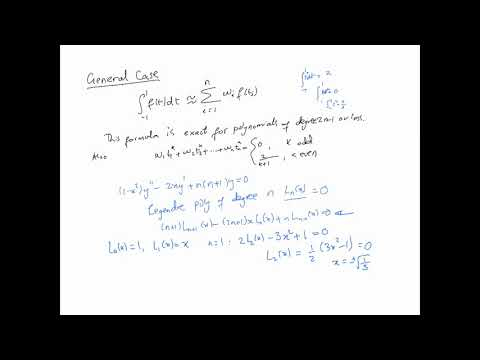

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("oKOsCvjTg3c",width=640,height=340)
# Direct link on YourTube: https://www.youtube.com/watch?v=oKOsCvjTg3c

### 3.3 Use SciPy's function
We are not going to write this code  on our own but will use a SciPy function instead.
Check out the example on how to use this SciPy function [here](https://www.geeksforgeeks.org/python-scipy-integrate-quadrature-method/)
and calculate the integral of $x^4-2x+1$ from $x=0$ to $x=2$ using the SciPy function.

In [6]:
from scipy import integrate

# Define the function to integrate
f = lambda x: x**4 - 2*x + 1

# Define the integration limits
a = 0
b = 2

# Perform the quadrature integration
result = integrate.quadrature(f, a, b)

print("Result:", result)

Result: (4.399999999999999, 3.552713678800501e-15)


---
# Part 4: Choosing an Integration Method

We have studied a number of different integration methods so far: the trapezoidal rule and Simpson's rule as well as adaptive versions, Romberg integration, and Gaussian integration.
You might well ask at this point: Which of all these methods is the best? Which one should I use, in practice, if I need to evaluate an integral?

There is no one answer to this question.
Which method you should use depends on the particular problem confronting you.
A good general principle, however, is that higher-order methods such as Romberg and Gaussian integration, which allow you to make accurate estimates of integrals using relatively few sample points, work best when applied to smooth, well behaved functions.
If your function is not smooth or is poorly behaved in some way, then simpler methods, and particularly the trapezoidal rule, are the way to go.
The reason is that any integration method knows about the value of the integrand only at its sample points.
If the integrand varies significantly between the sample points, then that variation will not be reflected in the computed value of the integral, which can lead to inaccurate results.
If you're evaluating an integral using only ten or twenty sample points, it's crucial that those points give a good picture of the integrand; if you join up the dots, the result should capture the shape of the function.
If it does not, then high-order methods using few sample points will not do a good job.

Bearing this principle in mind, here is a guide to the kinds of problems each of our integration methods is good for.

### The trapezoidal rule
The trapezoidal rule  is trivial to program, so if you have to implement a method from scratch, this is a good choice.
It doesn't converge very quickly, but sometimes you don't need great accuracy or can afford to use a large number of points.
It uses equally spaced sample points, which is appropriate for problems such as integrating data from laboratory experiments that are sampled at uniform time intervals.
The trapezoidal rule is also a good choice for poorly behaved functions: those that vary widely, contain singularities, or are noisy.
In its adaptive form it can give us a guaranteed accuracy for an integral, although it may take more computer time to achieve that accuracy than other methods.

### Simpson’s rule
Simpson's rule has many of the benefits of the trapezoidal rule, such as simplicity of programming and equally spaced sample points.
It gives greater accuracy than the trapezoidal rule with the same number of sample points, or the same accuracy with fewer points, but relies on higher-order approximation of the integrand, which can lead to problems if the integrand is noisy or otherwise not smooth.
Use it with caution if you are unsure of the nature of your integrand.
Its adaptive form provides a result of guaranteed accuracy, and does so faster than the equivalent trapezoidal rule calculation, but again may be less suitable for poorly behaved integrands.

###  Romberg integration
When using equally spaced sample points, Romberg integration is the quintessential higher-order integration method.
It gives exceptionally accurate estimates of integrals with a minimum number of sample points, plus error estimates that allow you to halt the calculation once you have achieved a desired accuracy.
Since it relies extrapolating answers from measurements of the integrand at only a few points, however, Romberg integration will not work well for wildly varying integrands, noisy integrands, or integrands with mathematically pathological behaviors like singularities.
It is best applied to smooth functions whose form can be determined accurately from only a small number of sample points.

### Gaussian quadrature
Gaussian quadrature has many of the same advantages as Romberg integration (potentially highly accurate estimates
from small numbers of sample points) as well as the same disadvantages (poor performance for badly behaved integrands).
It is also simple to program, though based on the preceding text, this may seem hard to believe.
The hard work of the method lies in the calculation of the integration points and weights; the Gaussian integral itself requires only the evaluation of a single sum.
It has the additional advantage over Romberg integration of still higher-order accuracy and indeed, in a certain formal sense, it is the highest-order, and hence potentially most accurate, integration rule possible.
The price you pay for this is that the integration points are unequally spaced.
If you need equally spaced points, then Gaussian quadrature is not the method for you.

---
## Assignment Wrap-up


Please submit your notebook **in ipynb format** to Gradescope.

**You must complete the pre-class survey in order to receive credit for the assignment!**